# <font color=#323232>Part 2: Transfer Learning</font>

### <font color=#333333>1. Import Libraries | Check for Available GPU | Set Dataset Locations</font>
#### <font color=#404040>&emsp;&emsp;1.1 Import the Necessary Libraries</font>
#### <font color=#404040>&emsp;&emsp;1.2 Check for Available GPU</font>
#### <font color=#404040>&emsp;&emsp;1.3 Set Dataset Locations</font>
### <font color=#333333>2. Resize Images | Set Batch Size | Create Train and Validation Datasets</font>
### <font color=#333333>3. Exploration of the Classes we're Working with and the Images of the Dataset</font>
#### <font color=#404040>&emsp;&emsp;3.1 Exploration of the Classes</font>
#### <font color=#404040>&emsp;&emsp;3.2 Some Sample Images from the Dataset</font>
### <font color=#333333>4. Transfer Learning</font>
#### <font color=#404040>&emsp;&emsp;4.1 Helper Functions</font>
#### <font color=#404040>&emsp;&emsp;4.2 Transfer Learning Models</font>
#### <font color=#404040>&emsp;&emsp;&emsp;&emsp;4.2.1 Transfer Learning with the Best Model</font>
#### <font color=#404040>&emsp;&emsp;&emsp;&emsp;4.2.2 Transfer Learning while Unfreezing More Layers</font>
#### <font color=#404040>&emsp;&emsp;&emsp;&emsp;4.2.3 Training all the Layers of the Final Model to Compare with the Transfer Learning Results</font>
#### <font color=#404040>&emsp;&emsp;&emsp;&emsp;4.2.4 Transfer Learning with the Final Model and Using only 10% of the Dataset</font>
#### <font color=#404040>&emsp;&emsp;&emsp;&emsp;4.2.5 Transfer Learning with the Final Model and Using only 10% of the Dataset with More Layers Trainable</font>
#### <font color=#404040>&emsp;&emsp;&emsp;&emsp;4.2.6 Training the Final Model from Scratch on the Indian Dataset Using Only 10% of the Dataset</font>
#### <font color=#404040>&emsp;&emsp;&emsp;&emsp;4.2.7 Training the ResNet Model on the Indian Dataset</font>
### <font color=#333333>5. Final Observations and Conclusion</font>

## 1. Import Libraries | Check for Available GPU | Set Dataset Locations

### 1.1 Import the Necessary Libraries

In [22]:
# Importing the necessary libraries
import time
from tabulate import tabulate
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

### 1.2 Check for Available GPU

In [23]:
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 1.3 Set Dataset Locations

The dataset used in this part is also from Kaggle. It contains images of birds from India:

https://www.kaggle.com/datasets/ichhadhari/indian-birds

Specifically there are a total of 30000 images in the training dataset divided into 25 classes. The validation dataset contains 7500 images. It is important to note that even though there are 1400 images per class, many of the images are the product of data augmentation. This will be more obvious later when we examine some random samples from the dataset.

In [24]:
# location of the training and validation data for the 525 birds dataset
train_dir = "/kaggle/input/indian-birds/Birds_25/train"
val_dir = "/kaggle/input/indian-birds/Birds_25/valid"

## 2. Resize Images | Set Batch Size | Create Train and Validation Datasets

The following code resizes the images to 180x180 and sets the batch size to 64.

In [25]:
image_size = (180, 180)
batch_size = 64

train_ds_indian = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds_indian = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

Found 30000 files belonging to 25 classes.
Found 7500 files belonging to 25 classes.


## 3. Exploration of the Classes we're Working with and the Images of the Dataset

### 3.1 Exploration of the Classes

In [26]:
class_names = train_ds_indian.class_names
num_classes = len(class_names)

print('This dataset contains', num_classes, 'bird species.')

This dataset contains 25 bird species.


### 3.2 Some Sample Images from the Dataset

A sample of 9 images in the dataset. As we can see, data augmentation has already been applied in this dataset.

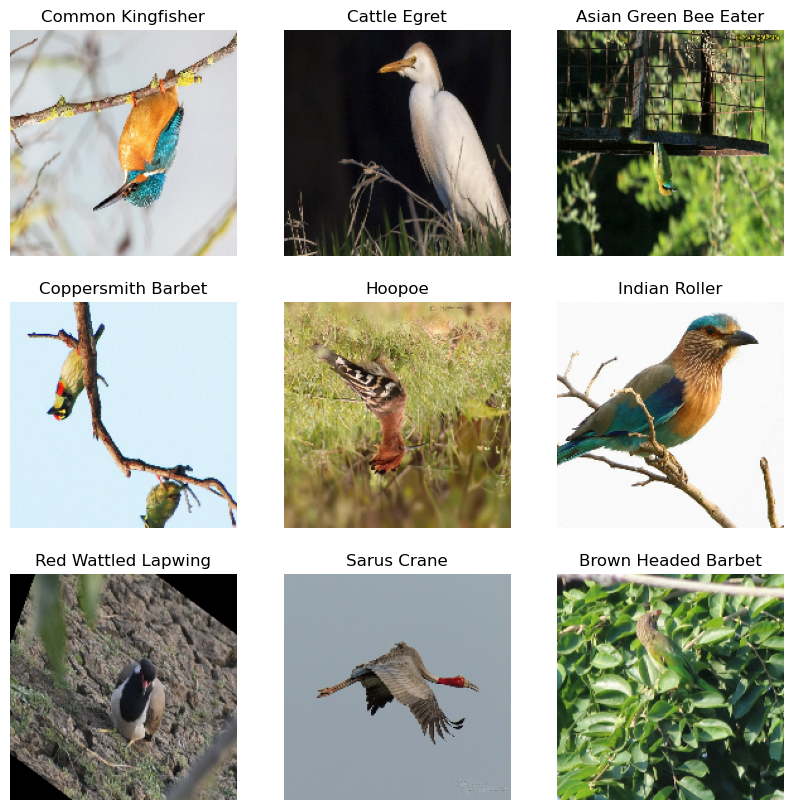

In [27]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds_indian.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        image = images[i].numpy().astype("uint8")
        label = labels[i].numpy()
        bird_name = class_names[label].replace("-", " ")
        plt.imshow(image)
        plt.title(bird_name)
        plt.axis("off")

## 4. Transfer Learning

### 4.1 Helper Functions

The helper function used are the same as the ones in the training of the CNN in part 1. A brief explanation about what each function does can be found in the comments.

In [28]:
# A function that displays the model layers and the parameters of each layer as well as the frozen (non-trainable) parameters
def display_model_stats(model):
    print(model.summary())

In [29]:
# A function to plot the training and validation accuracy and loss
def plot_model_accuracy_and_loss(metrics):
    acc = metrics.history["accuracy"]
    val_acc = metrics.history["val_accuracy"]
    loss = metrics.history["loss"]
    val_loss = metrics.history["val_loss"]
    epochs = range(1, len(acc) + 1)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot training and validation accuracy
    ax1.plot(epochs, acc, "r", label="Training accuracy")
    ax1.plot(epochs, val_acc, "g", label="Validation accuracy")
    ax1.set_title("Training and Validation accuracy")
    ax1.legend()

    # Plot training and validation loss
    ax2.plot(epochs, loss, "r", label="Training loss")
    ax2.plot(epochs, val_loss, "g", label="Validation loss")
    ax2.set_title("Training and Validation loss")
    ax2.legend()

    # Adjust the spacing between subplots
    fig.tight_layout()

    # Display the figure
    plt.show()

In [30]:
# An array that will store all training data for the models like time and epochs to extract general statistics later
global_model_stats = []

In [31]:
# A function to compile and fit the model that also returns metrics
def train_model(model, train_dataset, validation_dataset, epochs, early_stopping = False, save_model = False):
    # Compile the Model
    model.compile(loss="sparse_categorical_crossentropy",
             metrics=["accuracy"],
             optimizer="adam")
    
    # Start the timer
    start_time = time.time()
    
    # Check if the model is not improving validation loss and stop early
    # In this case it will always be False to help with visualizations
    if early_stopping == True:
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
        metrics = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset, callbacks=[es_callback])
    # Option to save the model
    elif save_model == True:
        checkpoint_filepath = '/kaggle/working/'+ model.name +'.h5'
        model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)
        metrics = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset, callbacks=[model_checkpoint_callback])
    else:
        metrics = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)
        
    # Calculate the model metrics
    end_time = time.time()
    training_time = int(end_time - start_time)
    training_time_per_epoch = round(training_time/epochs, 2)
    highest_train_accuracy = max(metrics.history['accuracy'])
    highest_val_accuracy = max(metrics.history['val_accuracy'])

    # Saving the model's metrics to the array
    global_model_stats.append([model.name, training_time, epochs, training_time_per_epoch, highest_train_accuracy, highest_val_accuracy])
    
    print('-----------------------------------------------------------------------------------')
    print(f'The training of the {model.name} required a total of {training_time} seconds for {epochs} epochs.')
    
    return metrics

### 4.2 Transfer Learning Models

#### 4.2.1 Transfer Learning with the Best Model

In the first experiment we are going to explore if the best model we saved from Part 1 can classify this new dataset with only the last (classification) layer trainable. What we're gonna do is freeze all the layers of this model and replace the final Dense layer with a new layer that will classify the 25 bird species of the Indian Birds dataset.

The first step is to load the model. Same as before, this code is recommended to run in Kaggle's platform, so the model has to be uploaded there and imported through the load_model function. The code in the next cell presumes that the model is uploaded in a folder named "best-model-525-birds". The model can be found in the folder "models" within this repositroy. In order to load the model locally, the path provided to the load_model function should be changed to the model's location.

After loading the model, the next step is to freeze (make non-trainable) all layers except the last one (classification layer). It is interesting to note that the new classifier layer has a significantly smaller number of parameters as the classes that need to be classified are alot less than our original dataset (525 vs 25).

In [32]:
# Load the pre-trained model
pretrained_model = tf.keras.models.load_model('/kaggle/input/best-model-525-birds/Model_with_Residual_Connections.h5')

for layer in pretrained_model.layers[:-1]:
    layer.trainable = False
    
new_output = tf.keras.layers.Dense(num_classes, activation='softmax')(pretrained_model.layers[-2].output)

model_indian_transfer = tf.keras.Model(inputs=pretrained_model.input, outputs=new_output, name = 'Indian_Birds_Transfer_Learning_Model')
model_indian_transfer.summary()

Model: "Indian_Birds_Transfer_Learning_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_137 (Conv2D)            (None, 178, 178, 32  896         ['input_21[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d_38 (MaxPooling2D  (None, 89, 89, 32)  0           ['conv2d_137[0][0]']             
 )                                                             

In [33]:
# Training of the model
model_indian_transfer_metrics = train_model(model_indian_transfer, train_ds_indian, val_ds_indian, 15)

Epoch 1/15


2023-06-21 17:23:23.364411: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inIndian_Birds_Transfer_Learning_Model/dropout_110/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


469/469 [==============================] - 176s 367ms/step - loss: 2.1447 - accuracy: 0.3989 - val_loss: 1.6040 - val_accuracy: 0.6495
Epoch 2/15
469/469 [==============================] - 182s 381ms/step - loss: 1.5647 - accuracy: 0.5593 - val_loss: 1.3740 - val_accuracy: 0.6807
Epoch 3/15
469/469 [==============================] - 179s 378ms/step - loss: 1.4447 - accuracy: 0.5840 - val_loss: 1.2759 - val_accuracy: 0.6984
Epoch 4/15
469/469 [==============================] - 171s 360ms/step - loss: 1.3958 - accuracy: 0.5981 - val_loss: 1.2225 - val_accuracy: 0.7091
Epoch 5/15
469/469 [==============================] - 178s 375ms/step - loss: 1.3631 - accuracy: 0.5999 - val_loss: 1.1893 - val_accuracy: 0.7129
Epoch 6/15
469/469 [==============================] - 173s 363ms/step - loss: 1.3531 - accuracy: 0.6044 - val_loss: 1.1641 - val_accuracy: 0.7128
Epoch 7/15
469/469 [==============================] - 178s 376ms/step - loss: 1.3397 - accuracy: 0.6077 - val_loss: 1.1487 - val_accura

The model we imported that was trained on the previous dataset managed to achieve around 70% accuracy in this new dataset after only 3-4 epochs. Though, after that the accuracy stopped increased something that was more or less expected as the most parameters of the model are frozen and cannot be trained. So practically, the rest of the epochs provided no value in terms of accuracy. A way to avoid this wasted training time is to add an early stopping callback while training the model. In this case I opted not to do this in order to explain what's happening more easily.

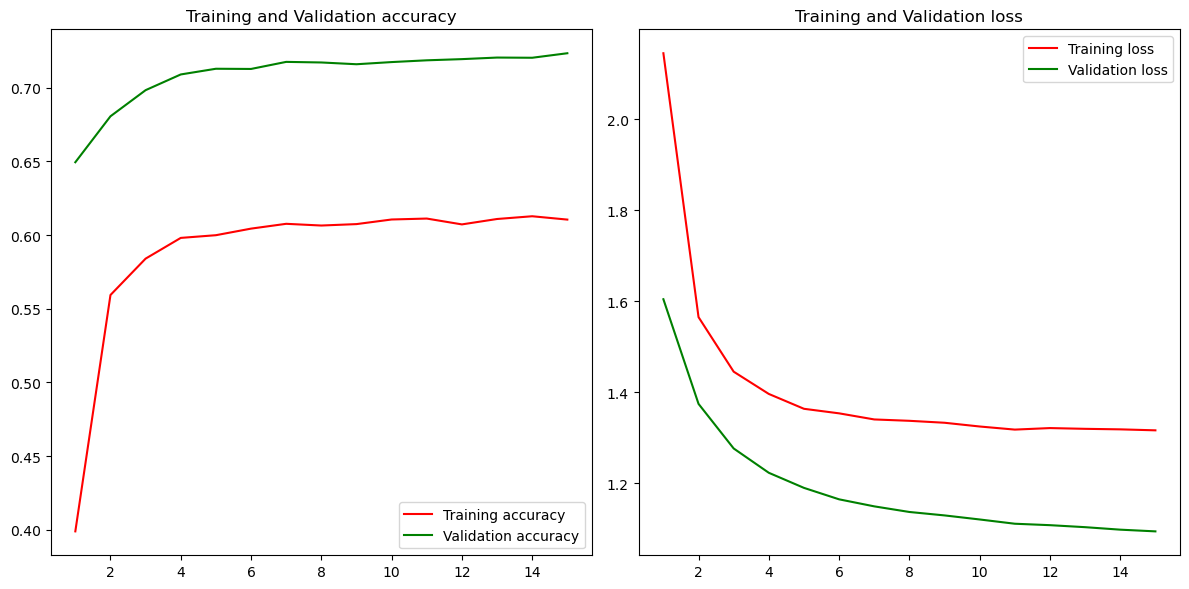

In [34]:
# Display stats
plot_model_accuracy_and_loss(model_indian_transfer_metrics)

#### 4.2.2 Transfer Learning while Unfreezing More Layers

In this experiment I will try also unfreezing the last convolutional block before the final Dense layer and see if that changes how fast the model trains or how quickly it can reach a high accuracy score.

In [35]:
# Load the pre-trained model
pretrained_model = tf.keras.models.load_model('/kaggle/input/best-model-525-birds/Model_with_Residual_Connections.h5')

# Unfreezing the last 9 layers which practically represent the last residual block and the classification layer
for layer in pretrained_model.layers[:-9]:
    layer.trainable = False

new_output = tf.keras.layers.Dense(num_classes, activation='softmax')(pretrained_model.layers[-2].output)

model_indian_transfer_2 = tf.keras.Model(inputs=pretrained_model.input, outputs=new_output, name = 'Indian_Birds_Transfer_Learning_Model_2')
model_indian_transfer_2.summary()

Model: "Indian_Birds_Transfer_Learning_Model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_137 (Conv2D)            (None, 178, 178, 32  896         ['input_21[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d_38 (MaxPooling2D  (None, 89, 89, 32)  0           ['conv2d_137[0][0]']             
 )                                                           

In [36]:
# Training of the model
model_indian_transfer_metrics_2 = train_model(model_indian_transfer_2, train_ds_indian, val_ds_indian, 15)

Epoch 1/15


2023-06-21 18:08:31.418376: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inIndian_Birds_Transfer_Learning_Model_2/dropout_110/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


469/469 [==============================] - 176s 361ms/step - loss: 1.7626 - accuracy: 0.4895 - val_loss: 0.9715 - val_accuracy: 0.7404
Epoch 2/15
469/469 [==============================] - 173s 364ms/step - loss: 1.0968 - accuracy: 0.6703 - val_loss: 0.8143 - val_accuracy: 0.7715
Epoch 3/15
469/469 [==============================] - 171s 360ms/step - loss: 0.9483 - accuracy: 0.7105 - val_loss: 0.7436 - val_accuracy: 0.7885
Epoch 4/15
469/469 [==============================] - 172s 363ms/step - loss: 0.8646 - accuracy: 0.7378 - val_loss: 0.6993 - val_accuracy: 0.8003
Epoch 5/15
469/469 [==============================] - 178s 374ms/step - loss: 0.7989 - accuracy: 0.7540 - val_loss: 0.6691 - val_accuracy: 0.8075
Epoch 6/15
469/469 [==============================] - 171s 359ms/step - loss: 0.7413 - accuracy: 0.7716 - val_loss: 0.6398 - val_accuracy: 0.8125
Epoch 7/15
469/469 [==============================] - 170s 357ms/step - loss: 0.7104 - accuracy: 0.7774 - val_loss: 0.6183 - val_accura

As the last residual block was notably large compared to the previous layers, the change we applied earlier allowed the model to train almost 2.500.000 of its total 6.400.000 parameters, which is a pretty significant number. As a result, the model managed to use the prior knowledge of the model we imported which was trained on a similar task and achieved close to 85% percentage in this new, different dataset.

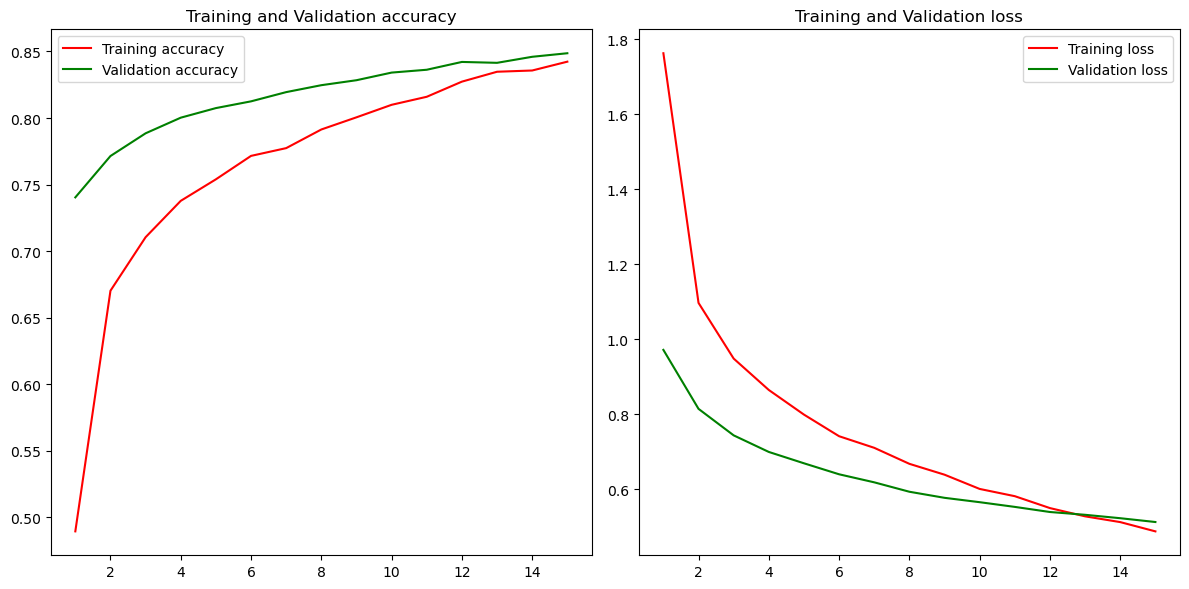

In [37]:
# Display stats
plot_model_accuracy_and_loss(model_indian_transfer_metrics_2)

#### 4.2.3 Training all the Layers of the Final Model to Compare with the Transfer Learning Results

The question is, though, what would happen if we tried to train a new model from scratch on the indan birds dataset? Would this be more or less efficient regarding both accuracy and training time? Practically what we're doing is using the same model architecture that yielded the best results in the 525 bird species dataset and then training this model in the new dataset without using any pretrained weights.

In [38]:
# A function to create the residual blocks
def residual_block(x, filters, stride=1, dropout_rate=0.2):
    identity = x

    # First convolutional layer
    x = layers.Conv2D(filters, (3,3), strides=stride, padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    # Second convolutional layer
    x = layers.Conv2D(filters, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    # Residual connection
    if stride > 1:
        identity = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', )(identity)
    x = layers.Add()([x, identity])
    x = layers.ReLU()(x)

    return x

In [39]:
input_shape = (180, 180, 3)
num_classes = 25

# Create the Model with Residual Connections
inputs = tf.keras.Input(shape=input_shape)

# Initial convolutional layers
x = layers.Conv2D(32, (3, 3), activation="relu", kernel_regularizer=keras.regularizers.L1L2())(inputs)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(64, (3, 3), activation="relu", kernel_regularizer=keras.regularizers.L1L2())(x)
x = layers.MaxPooling2D(2, 2)(x)

# Residual blocks
x = residual_block(x, filters=64)

x = residual_block(x, filters=128, stride=2)
x = residual_block(x, filters=128)

x = residual_block(x, filters=256, stride=2)
x = residual_block(x, filters=256)

x = residual_block(x, filters=512, stride=2)

# Final layers
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_indian_new = keras.Model(inputs, outputs, name = 'Indian_Birds_Best_Model_from_Scratch')

model_indian_new.summary()

Model: "Indian_Birds_Best_Model_from_Scratch"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 178, 178, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 89, 89, 32)   0           ['conv2d[0][0]']                 
                                                               

In [40]:
# Training of the model
model_indian_new_metrics = train_model(model_indian_new, train_ds_indian, val_ds_indian, 15)

Epoch 1/15


2023-06-21 18:51:54.911155: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inIndian_Birds_Best_Model_from_Scratch/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


469/469 [==============================] - 196s 387ms/step - loss: 3.1586 - accuracy: 0.1444 - val_loss: 2.4722 - val_accuracy: 0.2308
Epoch 2/15
469/469 [==============================] - 186s 392ms/step - loss: 2.1712 - accuracy: 0.3076 - val_loss: 1.9140 - val_accuracy: 0.4003
Epoch 3/15
469/469 [==============================] - 182s 384ms/step - loss: 1.7991 - accuracy: 0.4209 - val_loss: 1.6392 - val_accuracy: 0.4697
Epoch 4/15
469/469 [==============================] - 184s 387ms/step - loss: 1.5311 - accuracy: 0.5112 - val_loss: 1.4080 - val_accuracy: 0.5636
Epoch 5/15
469/469 [==============================] - 184s 385ms/step - loss: 1.2814 - accuracy: 0.5950 - val_loss: 1.2416 - val_accuracy: 0.6296
Epoch 6/15
469/469 [==============================] - 190s 401ms/step - loss: 1.0883 - accuracy: 0.6609 - val_loss: 1.0416 - val_accuracy: 0.6812
Epoch 7/15
469/469 [==============================] - 200s 421ms/step - loss: 0.9393 - accuracy: 0.7071 - val_loss: 1.1079 - val_accura

After training this model for 15 epochs we can see that the validation accuracy is lower than the one achieved in the transfer learning model. Also the model took more time to train those 15 epochs as it had to adjust a greater number of parameters. From the following plot it is obvious, tough,  that if the training were to resume for more epochs we would probably surpass the pretrained model's accuracy. The main benefit of transfer learning is that we can use the weight of a model that was trained on a similar task to achieve high accuracy on a similar dataset, thus reducing the training time significantly. Of course, training a model from scratch is expected to give better results after a large number of epochs, but this requires a lot of computational power and more time that can be reduced significantly if we use transfer learning.

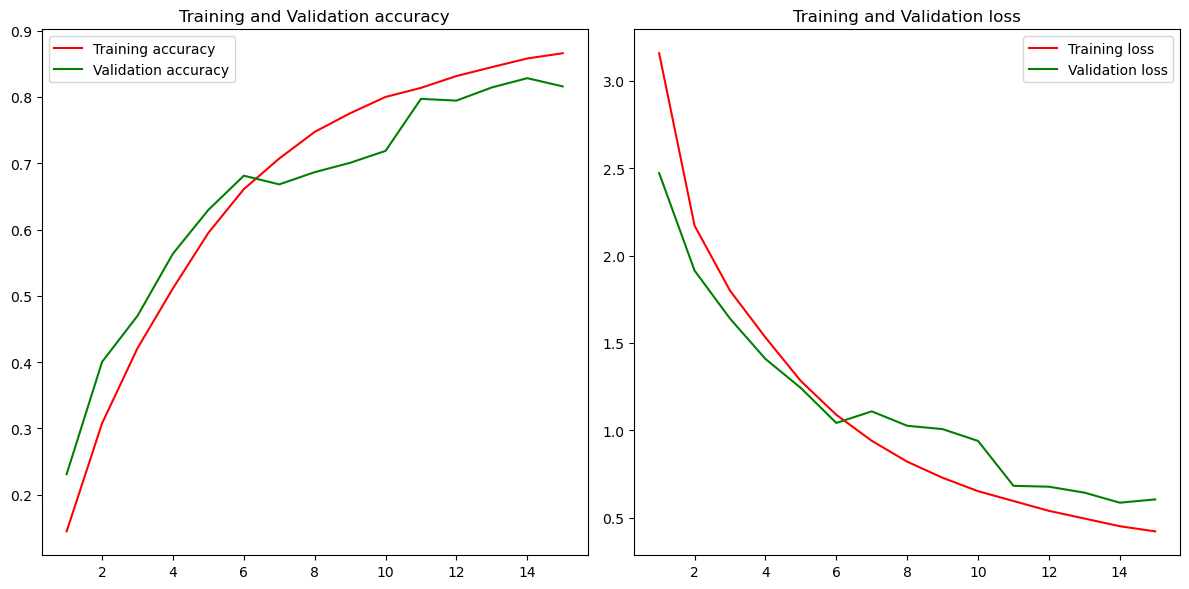

In [41]:
# Display stats
plot_model_accuracy_and_loss(model_indian_new_metrics)

#### 4.2.4 Transfer Learning with the Final Model and Using only 10% of the Dataset

In the following 3 experiments I'm going to try reducing the size of the training and validation datasets to 10% of the original size and see how that affects the results from the 3 models we examined earlier.

In [43]:
image_size = (180, 180)    
batch_size = 64

train_ds_indian_10_percent = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
    validation_split=0.9,
    subset="training"
)

val_ds_indian_10_percent = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
    validation_split=0.1,
    subset="validation"
)

Found 30000 files belonging to 25 classes.
Using 3000 files for training.
Found 7500 files belonging to 25 classes.
Using 750 files for validation.


In [44]:
# Load the pre-trained model
pretrained_model = tf.keras.models.load_model('/kaggle/input/best-model-525-birds/Model_with_Residual_Connections.h5')

# Unfreezing the last layer
for layer in pretrained_model.layers[:-1]:
    layer.trainable = False

new_output = tf.keras.layers.Dense(num_classes, activation='softmax')(pretrained_model.layers[-2].output)

model_indian_transfer_3 = tf.keras.Model(inputs=pretrained_model.input, outputs=new_output, name = 'Indian_Birds_Transfer_Learning_Best_Model_Small_Dataset')
model_indian_transfer_3.summary()

Model: "Indian_Birds_Transfer_Learning_Best_Model_Small_Dataset"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_137 (Conv2D)            (None, 178, 178, 32  896         ['input_21[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d_38 (MaxPooling2D  (None, 89, 89, 32)  0           ['conv2d_137[0][0]']             
 )                                          

In [45]:
# Training of the model
model_indian_transfer_metrics_3 = train_model(model_indian_transfer_3, train_ds_indian_10_percent, val_ds_indian_10_percent, 15)

Epoch 1/15


2023-06-21 19:43:08.197834: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inIndian_Birds_Transfer_Learning_Best_Model_Small_Dataset/dropout_110/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


47/47 [==============================] - 22s 369ms/step - loss: 3.1897 - accuracy: 0.0877 - val_loss: 2.8106 - val_accuracy: 0.2493
Epoch 2/15
47/47 [==============================] - 18s 337ms/step - loss: 2.6739 - accuracy: 0.2287 - val_loss: 2.4714 - val_accuracy: 0.4173
Epoch 3/15
47/47 [==============================] - 17s 320ms/step - loss: 2.3473 - accuracy: 0.3413 - val_loss: 2.2335 - val_accuracy: 0.4933
Epoch 4/15
47/47 [==============================] - 18s 325ms/step - loss: 2.1387 - accuracy: 0.4073 - val_loss: 2.0637 - val_accuracy: 0.5493
Epoch 5/15
47/47 [==============================] - 18s 336ms/step - loss: 1.9666 - accuracy: 0.4640 - val_loss: 1.9368 - val_accuracy: 0.5853
Epoch 6/15
47/47 [==============================] - 17s 325ms/step - loss: 1.8462 - accuracy: 0.4970 - val_loss: 1.8399 - val_accuracy: 0.5987
Epoch 7/15
47/47 [==============================] - 20s 375ms/step - loss: 1.7538 - accuracy: 0.5163 - val_loss: 1.7593 - val_accuracy: 0.6213
Epoch 8/15

Obviously, reducing the size of the dataset also slashed the training time by a significant margin, though the accuracy of the model was still close to 66%. This shows how transfer learning can help leverage prior knowledge to make effective models even when the dataset we're working with is relatively small.

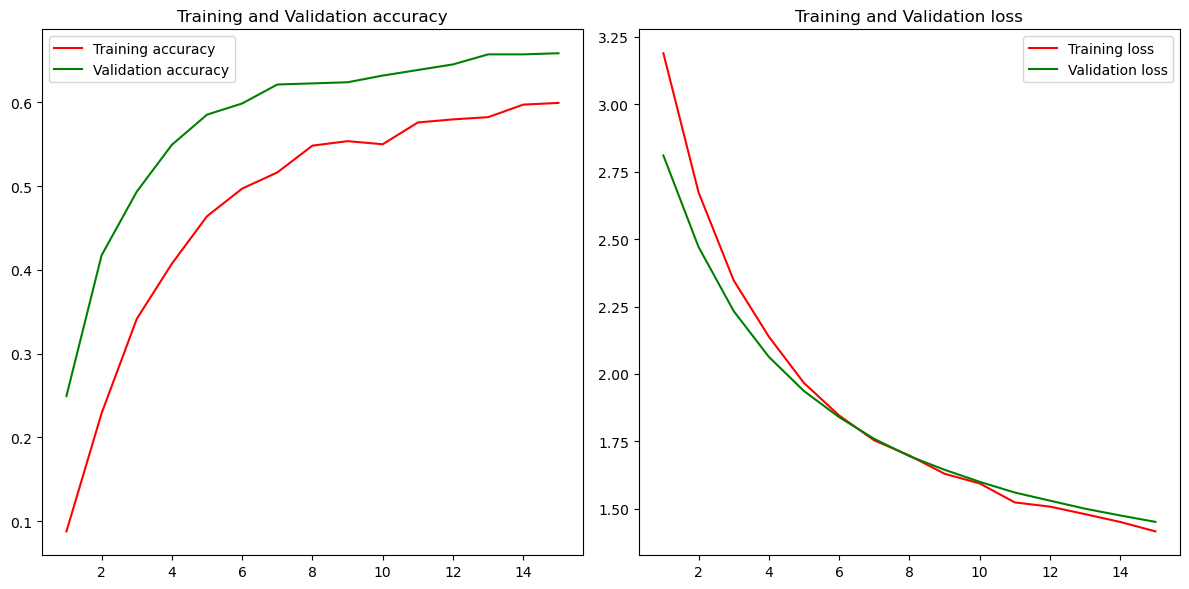

In [46]:
# Display stats
plot_model_accuracy_and_loss(model_indian_transfer_metrics_3)

#### 4.2.5 Transfer Learning with the Final Model and Using only 10% of the Dataset with More Layers Trainable

In this experiment we are goint to find out how the pretrained model fares in this new smaller dataset if it can also train the last residual block except the final classifier layer.

In [47]:
# Load the pre-trained model
pretrained_model = tf.keras.models.load_model('/kaggle/input/best-model-525-birds/Model_with_Residual_Connections.h5')

# Unfreezing the last layer
for layer in pretrained_model.layers[:-9]:
    layer.trainable = False

new_output = tf.keras.layers.Dense(num_classes, activation='softmax')(pretrained_model.layers[-2].output)

model_indian_transfer_4 = tf.keras.Model(inputs=pretrained_model.input, outputs=new_output, name = 'Indian_Birds_Transfer_Learning_Best_Model_More_Layers_Trainable_Small_Dataset')
model_indian_transfer_4.summary()

Model: "Indian_Birds_Transfer_Learning_Best_Model_More_Layers_Trainable_Small_Dataset"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_137 (Conv2D)            (None, 178, 178, 32  896         ['input_21[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d_38 (MaxPooling2D  (None, 89, 89, 32)  0           ['conv2d_137[0][0]']             
 )                    

In [48]:
# Training of the model
model_indian_transfer_metrics_4 = train_model(model_indian_transfer_4, train_ds_indian_10_percent, val_ds_indian_10_percent, 15)

Epoch 1/15


2023-06-21 19:48:04.723870: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inIndian_Birds_Transfer_Learning_Best_Model_More_Layers_Trainable_Small_Dataset/dropout_110/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


47/47 [==============================] - 23s 350ms/step - loss: 3.0925 - accuracy: 0.1300 - val_loss: 2.5750 - val_accuracy: 0.3507
Epoch 2/15
47/47 [==============================] - 18s 329ms/step - loss: 2.3034 - accuracy: 0.3473 - val_loss: 2.0115 - val_accuracy: 0.5347
Epoch 3/15
47/47 [==============================] - 19s 349ms/step - loss: 1.8232 - accuracy: 0.4723 - val_loss: 1.6005 - val_accuracy: 0.6107
Epoch 4/15
47/47 [==============================] - 18s 328ms/step - loss: 1.5542 - accuracy: 0.5507 - val_loss: 1.3576 - val_accuracy: 0.6413
Epoch 5/15
47/47 [==============================] - 18s 332ms/step - loss: 1.3596 - accuracy: 0.6007 - val_loss: 1.2052 - val_accuracy: 0.6680
Epoch 6/15
47/47 [==============================] - 18s 340ms/step - loss: 1.2196 - accuracy: 0.6287 - val_loss: 1.1134 - val_accuracy: 0.6800
Epoch 7/15
47/47 [==============================] - 18s 330ms/step - loss: 1.0802 - accuracy: 0.6800 - val_loss: 1.0504 - val_accuracy: 0.6920
Epoch 8/15

Unfreezing of the last residual block increased the accuracy of the transfer learning model by a significant margin without increasing the training time. This time the model approaches an accuracy of 74% after only 15 epochs of training on the smaller dataset.

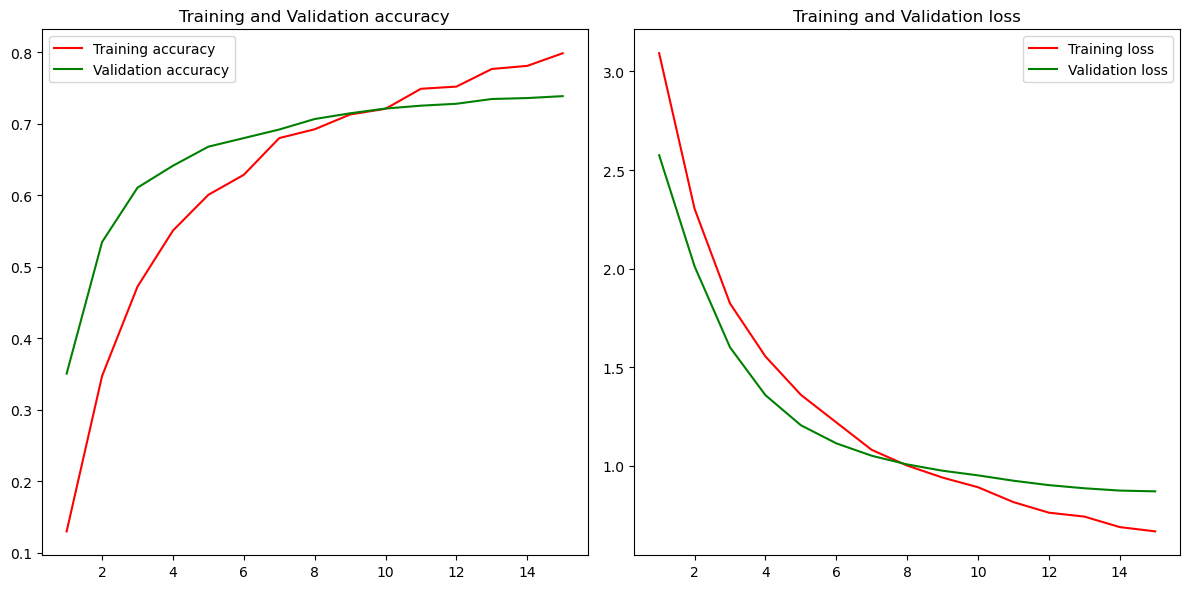

In [49]:
# Display stats
plot_model_accuracy_and_loss(model_indian_transfer_metrics_4)

#### 4.2.6 Training the Final Model from Scratch on the Indian Dataset Using Only 10% of the Dataset

Now it is time to see if it is possible to train a new model on the smaller dataset. Would this model compare to the results we achieved with the transfer learning models? Again I'm using the same model architecture but this time there are no pretrained weights.

In [50]:
# Create the Model with Residual Connections
inputs = tf.keras.Input(shape=input_shape)

# Initial convolutional layers
x = layers.Conv2D(32, (3, 3), activation="relu", kernel_regularizer=keras.regularizers.L1L2())(inputs)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(64, (3, 3), activation="relu", kernel_regularizer=keras.regularizers.L1L2())(x)
x = layers.MaxPooling2D(2, 2)(x)

# Residual blocks
x = residual_block(x, filters=64)

x = residual_block(x, filters=128, stride=2)
x = residual_block(x, filters=128)

x = residual_block(x, filters=256, stride=2)
x = residual_block(x, filters=256)

x = residual_block(x, filters=512, stride=2)

# Final layers
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_indian_new_small_dataset = keras.Model(inputs, outputs, name = 'Indian_Birds_Model_from_Scratch_Small_Dataset')

model_indian_new_small_dataset.summary()

Model: "Indian_Birds_Model_from_Scratch_Small_Dataset"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_17 (Conv2D)             (None, 178, 178, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 89, 89, 32)  0           ['conv2d_17[0][0]']              
                                                      

In [51]:
# Training of the model
model_indian_new_small_dataset_metrics = train_model(model_indian_new_small_dataset, train_ds_indian_10_percent, val_ds_indian_10_percent, 15)

Epoch 1/15


2023-06-21 19:53:11.533595: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inIndian_Birds_Model_from_Scratch_Small_Dataset/dropout_13/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


47/47 [==============================] - 33s 398ms/step - loss: 6.7619 - accuracy: 0.0613 - val_loss: 155.0854 - val_accuracy: 0.0373
Epoch 2/15
47/47 [==============================] - 20s 373ms/step - loss: 3.2402 - accuracy: 0.1073 - val_loss: 21.4844 - val_accuracy: 0.0307
Epoch 3/15
47/47 [==============================] - 21s 393ms/step - loss: 2.8853 - accuracy: 0.1307 - val_loss: 3.3856 - val_accuracy: 0.1187
Epoch 4/15
47/47 [==============================] - 21s 398ms/step - loss: 2.7267 - accuracy: 0.1730 - val_loss: 2.8281 - val_accuracy: 0.1333
Epoch 5/15
47/47 [==============================] - 21s 401ms/step - loss: 2.6360 - accuracy: 0.1820 - val_loss: 2.5642 - val_accuracy: 0.2413
Epoch 6/15
47/47 [==============================] - 20s 387ms/step - loss: 2.5347 - accuracy: 0.2123 - val_loss: 2.4967 - val_accuracy: 0.2440
Epoch 7/15
47/47 [==============================] - 20s 372ms/step - loss: 2.4434 - accuracy: 0.2380 - val_loss: 2.4201 - val_accuracy: 0.2707
Epoch 8

Training this model from scratch on such a small dataset didn't even managed to breach the 40% accuracy barrier as it is obvious from the following plots. Would this accuracy improve with further training of the model? We cannot say for sure but it seems like the model was probably too complex for this small dataset so I guess the pretrained models got this one.

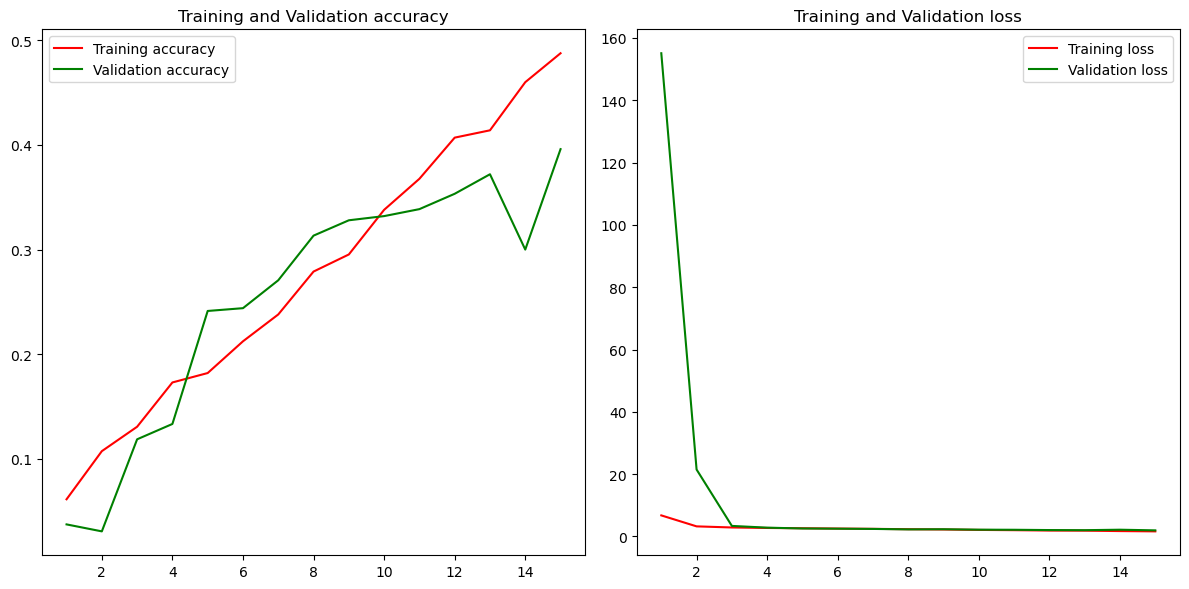

In [52]:
# Display stats
plot_model_accuracy_and_loss(model_indian_new_small_dataset_metrics)

#### 4.2.7 Transfer Learning with the ResNet Model on the Indian Dataset

For this last part I'm going to examine one of the most popular models for image classification, namely the ResNet model trained on the ImageNet dataset. When importing the model, I'm discarding the classifier layer, and adding a GlobalMaxPooling2D layer and a Dropout layer before the final classification layer for the 25 bird species of India. Once again, only the last layer will be trainable and I'm going to explore the metrics of this model.

In [64]:
from tensorflow.keras.applications import ResNet50

# Load the pre-trained ResNet50 model
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers
for layer in resnet_model.layers:
    layer.trainable = False

resnet_model_indian_dataset = tf.keras.Sequential([
    resnet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
    
resnet_model_indian_dataset.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_28 (Dropout)        (None, 2048)              0         
                                                                 
 dense_13 (Dense)            (None, 25)                51225     
                                                                 
Total params: 23,638,937
Trainable params: 51,225
Non-trainable params: 23,587,712
_________________________________________________________________


In [65]:
# Training of the model
resnet_model_indian_dataset_metrics = train_model(resnet_model_indian_dataset, train_ds_indian, val_ds_indian, 15)

Epoch 1/15
469/469 [==============================] - 209s 432ms/step - loss: 1.5054 - accuracy: 0.5724 - val_loss: 0.7224 - val_accuracy: 0.7804
Epoch 2/15
469/469 [==============================] - 184s 387ms/step - loss: 0.8896 - accuracy: 0.7307 - val_loss: 0.6156 - val_accuracy: 0.8060
Epoch 3/15
469/469 [==============================] - 183s 385ms/step - loss: 0.7962 - accuracy: 0.7571 - val_loss: 0.5811 - val_accuracy: 0.8125
Epoch 4/15
469/469 [==============================] - 192s 404ms/step - loss: 0.7417 - accuracy: 0.7705 - val_loss: 0.5556 - val_accuracy: 0.8263
Epoch 5/15
469/469 [==============================] - 185s 387ms/step - loss: 0.7215 - accuracy: 0.7785 - val_loss: 0.5449 - val_accuracy: 0.8284
Epoch 6/15
469/469 [==============================] - 187s 394ms/step - loss: 0.7206 - accuracy: 0.7787 - val_loss: 0.5437 - val_accuracy: 0.8263
Epoch 7/15
469/469 [==============================] - 183s 386ms/step - loss: 0.6930 - accuracy: 0.7869 - val_loss: 0.5564 -

After only 15 epochs, the ResNet model achieved around 84% in the Indian birds dataset. Actually, it is obvious from the plot that after only 2 epochs, the model already has above 80% accuracy on the dataset.

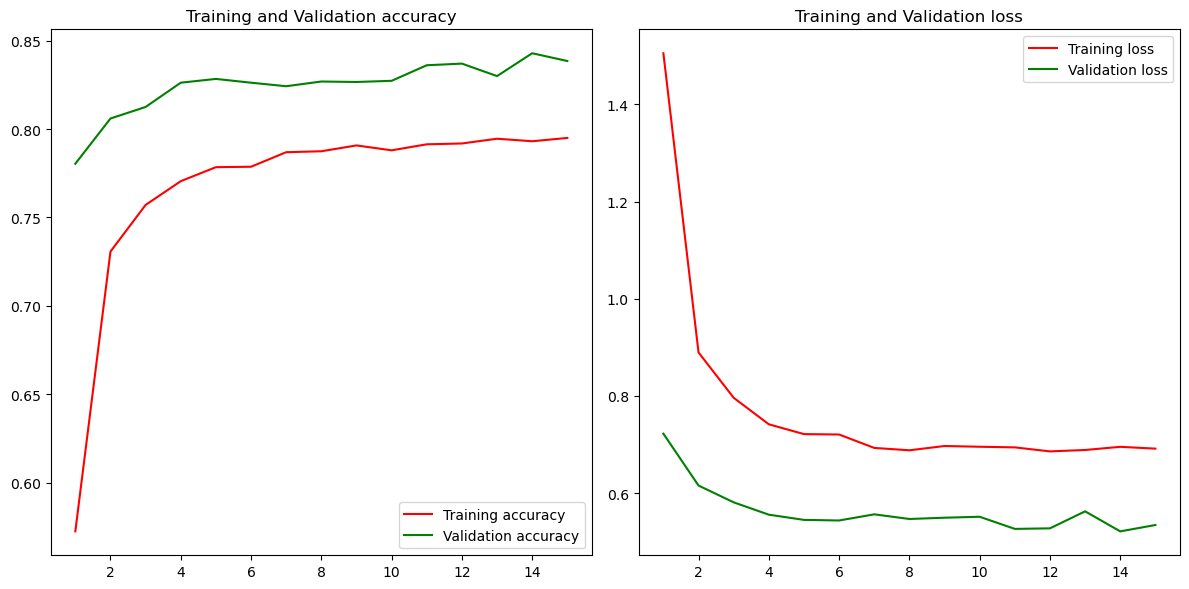

In [66]:
# Display stats
plot_model_accuracy_and_loss(resnet_model_indian_dataset_metrics)

## 5. Final Observations and Conclusion

As a closing statement, we could say that in most cases it is better to finetune a pretrained model on a similar task than train a new model from scratch on most datasets. Transfer learning allows us to use the prior knowledge of similar models, thus cutting down both training time and computational requirements. Especially for smaller datasets, transfer learning models can achieve good results while this is not the case for most models without prior knowledge.

In [67]:
print(tabulate(global_model_stats, headers=['Model Name', 'Training Time', 'Number of Epochs', 'Training Time per Epoch', 'Training Accuracy', 'Validation Accuracy'], tablefmt="fancy_grid"))

╒═══════════════════════════════════════════════════════════════════════════════╤═════════════════╤════════════════════╤═══════════════════════════╤═════════════════════╤═══════════════════════╕
│ Model Name                                                                    │   Training Time │   Number of Epochs │   Training Time per Epoch │   Training Accuracy │   Validation Accuracy │
╞═══════════════════════════════════════════════════════════════════════════════╪═════════════════╪════════════════════╪═══════════════════════════╪═════════════════════╪═══════════════════════╡
│ Indian_Birds_Transfer_Learning_Model                                          │            2706 │                 15 │                    180.4  │            0.6128   │              0.723467 │
├───────────────────────────────────────────────────────────────────────────────┼─────────────────┼────────────────────┼───────────────────────────┼─────────────────────┼───────────────────────┤
│ Indian_Birds_Transfer_L